<a href="https://colab.research.google.com/github/nagnimit03/Food101-EfficientNets-ComputerVision/blob/main/Food_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will be using Mixed precision training as it occupies less space in the memory so it will be faster for processing. So we will be using runtime type as GPU. We will using Tesla T4 as a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c956b825-096b-246c-5905-2528018bb319)


We will be using Tensroflow dataset Food 101 which contains 101 food categories and over 100,000 images. the link to the dataset is - https://www.tensorflow.org/datasets/catalog/food101

It will help us to download data which is already in tensor format

In [ ]:
 ##using tensorflow datasets to download the data
 import tensorflow_datasets as tfds
 import tensorflow as tf
 import numpy as np

In the below code we have used following parameters -
1. name - name of the dataset - food 101 in our case
2. split - split refers to the sets we want here food 101 consists of training and validation datasets
3.shuffle_files - setting this parameter as True will shuffle our image files
3. as_supervised - setting this parameter to True will also provide us with labels of the image eg pizza's image will come under a directory pizza
5.with_info - setting this parameter to true will give us the metadata of the images. we have created a variable ds_info for storing the metadata

In [ ]:
### loading food 101 dataset ( takes 5-6 minutes)
(train_data,test_data),ds_info=tfds.load(name="food101",
                                         split=["train","validation"],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5PCKYW/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5PCKYW/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
### get the class names
class_names=ds_info.features['label'].names

In [ ]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
sample_data=train_data.take(1)

In [ ]:
sample_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image,label in sample_data:
  print("Image Shape: "+str(image.shape)+"\n"+
        "Image datatype: "+str(image.dtype)+"\n"+
        "Target Label: "+str(label)+"\n"+
        "Target Class: "+class_names[label.numpy()])

Image Shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Target Label: tf.Tensor(18, shape=(), dtype=int64)
Target Class: chicken_curry


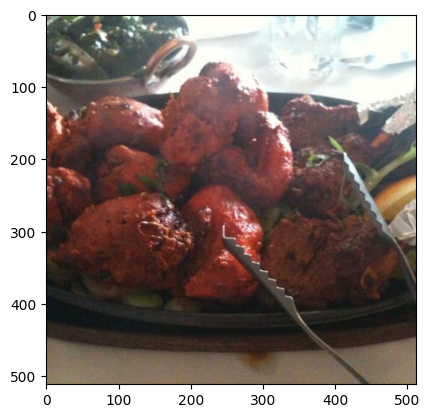

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)

We will need to create a functions which converts all the image to the same size ...neural networks work best on 224,224 and we will convert the datatype to float. We would need to rescale the pixel values also but it would be depenmding upon the architecture we use. Since we will be using efficientnet we don't need to rescale as rescaling layer is already built in the architecture but if we use restnets we might need to rescale the pixel values.

In [ ]:
####creating preprocessing function for the data
def preprocess_image(image,label,img_shape=224):
  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label


In [ ]:
###preprocess a single sample
preprocessed_image=preprocess_image(image,label)[0]
print("Image Shape: "+str(preprocessed_image.shape)+"\n"+
        "Image datatype: "+str(preprocessed_image.dtype)+"\n"+
        "Target Label: "+str(label)+"\n"+
        "Target Class: "+class_names[label.numpy()])

Image Shape: (224, 224, 3)
Image datatype: <dtype: 'float32'>
Target Label: tf.Tensor(18, shape=(), dtype=int64)
Target Class: chicken_curry


In [ ]:
### map preprocessing function to training data
## parallize it as well so as to maximum utilize all the compute power
train_data=train_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
###shuffle train data and turn it into batch and prefetch it
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
### doing it similarly with the test data
test_data=test_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
test_data=test_data.batch(batch_size=32).prefetch(buffer_size=len(test_data))

In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

CREATING A CALLBACKS
We will be creating a couple of callbacks to help us while our model trains.
1. Tensorboard callback to log our traingn result and check the same performance on our testing data
2. Model Checkpoint callbaord - Creating a checkpoint to save our model weight

In [ ]:
import datetime
def create_tensorboard_callback(directory_name,experiment_name):
  target_folder=directory_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  return tf.keras.callbacks.TensorBoard(
      log_dir=target_folder
  )

In [ ]:
checkpoint_path="Model_checkpoints/checkpoint.ckpt"

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

SETTING UP MIXED PRECISION TRAINING

Mixed precision utilizes a combination of float32 and float 16 to speed up the model performance

In [ ]:
from tensorflow.keras import mixed_precision

In [ ]:
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
#### creating the model
def getModel(numberOfLayersToTune):
  base_model=tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable=False
  if(numberOfLayersToTune!=0):
    base_model.trainable=True
    for layer in base_model.layers[:-(numberOfLayersToTune)]:
      layer.trainable=False

  inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
  x=base_model(inputs,training=False)
  x=tf.keras.layers.GlobalAveragePooling2D()(x)
  x=tf.keras.layers.Dense(len(class_names))(x)
  outputs=tf.keras.layers.Activation("softmax",dtype=tf.float32,name="output_float_32")(x)
  model=tf.keras.Model(inputs,outputs)

  return model


In [ ]:
###compiling the model
def compileModel(model,lr):
  model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
    )
  model.summary()




First I have created a feature exctration model which uses architecture of efficientnetB0 Model. I will be using this model as a base for fine tuning layers of this current architecture.

In [ ]:
###building a feature extraction model
feature_extraction_model=getModel(0)

compileModel(feature_extraction_model,0.001)


history_0=feature_extraction_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[
        checkpoint_callback,
        create_tensorboard_callback("Tensorboard_Training_Logs","Feature_Extraction_Model_1")
        ]
)

16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 output_float_32 (Activation  (None, 101)              0         
 )                                                               
                                                              

Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.7185 - accuracy: 0.5819
Epoch 1: val_loss improved from inf to 1.12641, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 217s 84ms/step - loss: 1.7185 - accuracy: 0.5819 - val_loss: 1.1264 - val_accuracy: 0.6984
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.2004 - accuracy: 0.6887
Epoch 2: val_loss improved from 1.12641 to 1.03454, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 200s 83ms/step - loss: 1.2004 - accuracy: 0.6887 - val_loss: 1.0345 - val_accuracy: 0.7193
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.0546 - accuracy: 0.7244
Epoch 3: val_loss improved from 1.03454 to 0.99030, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 198s 82ms/step - loss: 1.0546 - accuracy: 0.7244 - val_loss: 0.9903 - val_accuracy: 0.7341

With this architecture I was able to achieve an accuracy of 73%. Now I will try to tune the layers of models 50 , 100 and then all the layers and finally use the model which gives us the best validation accuracy

In [ ]:
results_feature_extraction_model=feature_extraction_model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 0.9794 - accuracy: 0.7316


The below function will give us two graphs that will demonstrate how training and testing accuracy deviate from each. This will be a good demonstration to determine overfitting

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  training_accuracy=history.history['accuracy']
  testing_accuracy=history.history['val_accuracy']
  training_loss=history.history['loss']
  testing_loss=history.history['val_loss']
  epochs=range(len(history.history['loss']))

  #plot loss
  plt.plot(epochs,training_loss,label="training Loss")
  plt.plot(epochs,testing_loss,label="Testing Loss")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs,training_accuracy,label="training Accuracy")
  plt.plot(epochs,testing_accuracy,label="Testing Accuracy")
  plt.legend()

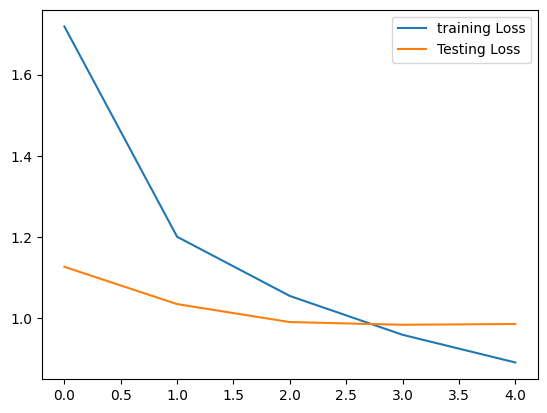

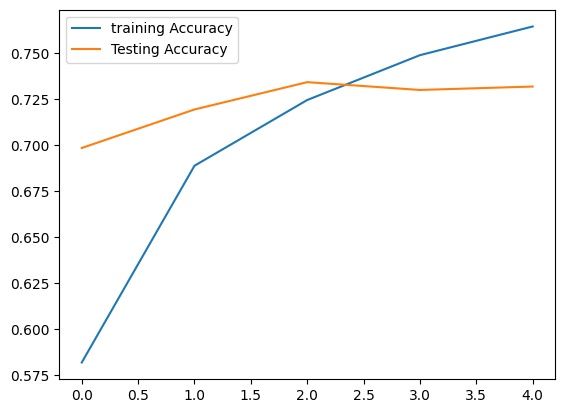

In [ ]:
plot_loss_curves(history_0)

As per the above graphs , we can see that both the curves are pretty close to each other. This is what I want as this is a clear indication that until now no overfitting happens.

The below callback is Early Stopping callback. When we fine tune a model , if the monitored quantity does not improve aftrer a certain number of epochs , we will not train the model further

In [ ]:
early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=0,
    patience=4
)

This is another model where I will be tuning last 50 layers of our feature extraction model and will try to evaluate the perofrmance on testing data

In [ ]:
fine_tune_model_last_50=getModel(50)

compileModel(fine_tune_model_last_50,0.0001)

history_1=fine_tune_model_last_50.fit(
    train_data,
    epochs=15,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    initial_epoch=history_0.epoch[-1],
    validation_steps=int(0.15*len(test_data)),
    callbacks=[early_stopping_callback,checkpoint_callback,
               create_tensorboard_callback("Tensorboard_Training_Logs","Fine_Tuning_Model_1_last_50")]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 output_float_32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 2,656,245
Non-tra

Epoch 5/15
2368/2368 [==============================] - ETA: 0s - loss: 1.6833 - accuracy: 0.5727
Epoch 5: val_loss improved from 0.98368 to 0.97490, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 232s 88ms/step - loss: 1.6833 - accuracy: 0.5727 - val_loss: 0.9749 - val_accuracy: 0.7256
Epoch 6/15
2368/2368 [==============================] - ETA: 0s - loss: 0.9632 - accuracy: 0.7403
Epoch 6: val_loss improved from 0.97490 to 0.85266, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 211s 88ms/step - loss: 0.9632 - accuracy: 0.7403 - val_loss: 0.8527 - val_accuracy: 0.7638
Epoch 7/15
2367/2368 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.8147
Epoch 7: val_loss improved from 0.85266 to 0.84123, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 216s 90ms/step - loss: 0.6722 - accuracy: 0.8147 - val_loss: 0.8412 - val_accuracy:

In [ ]:
fine_tune_model_last_50_results=fine_tune_model_last_50.evaluate(test_data)

790/790 [==============================] - 59s 74ms/step - loss: 1.3541 - accuracy: 0.7520


When I tune the last 50 layers of model , I achieved an accuracy of 75% which is better than our feature extraction model.

Similary , the below function is a slight modification to our above. Here what I have done is created a benchmark from where fine tuning actually starts but the intention remains same is that after the epoch from which fine tuning starts does our model began overfitting

In [ ]:
import matplotlib.pyplot as plt

def compare_history(original_history,new_history,initial_epochs=5):
  training_accuracy=original_history.history['accuracy']
  testing_accuracy=original_history.history['val_accuracy']
  training_loss=original_history.history['loss']
  testing_loss=original_history.history['val_loss']


  total_training_accuracy=training_accuracy+new_history.history['accuracy']
  total_testing_accuracy=testing_accuracy+new_history.history['val_accuracy']
  total_training_loss=training_loss+new_history.history['loss']
  total_testing_loss=testing_loss+new_history.history['val_loss']

  #plot accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_training_accuracy,label="training Accuracy")
  plt.plot(total_testing_accuracy,label="Testing Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="start fine tuning")
  plt.legend()

  #plot loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_training_loss,label="training Loss")
  plt.plot(total_testing_loss,label="Testing Loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="start fine tuning")
  plt.legend()

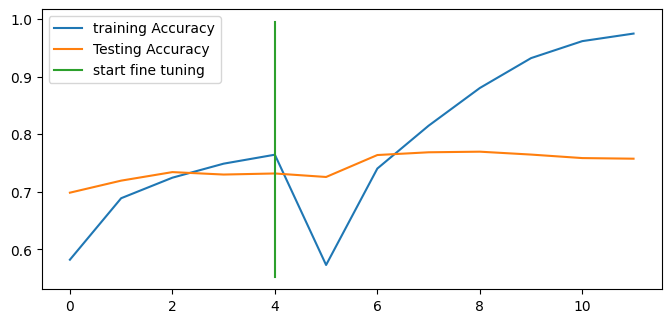

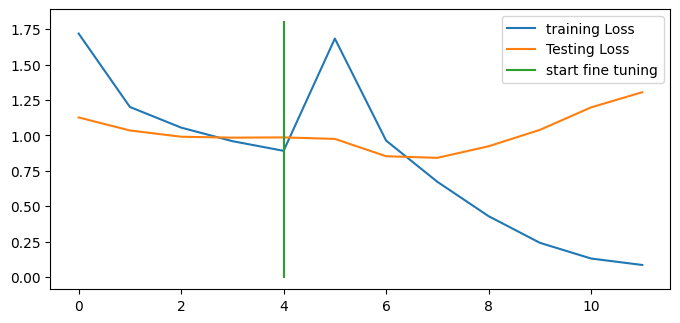

In [ ]:
compare_history(history_0,history_1)

As per the above graphs , we see that fine tuning begins from 4th epoch. From the distance between 2 graphs we do observe some overfitting as there is a considerable gap in both training and testing accuracy as well as training and validation loss. This can also be justified from our training model results as we were able to achieve a training accuracy of approx 94% but a testing accuracy of 75% only.

Below we see that we have another version of our feature extraction model in which we have trained last 100 layers of our model.

In [ ]:
fine_tune_model_last_100=getModel(100)

compileModel(fine_tune_model_last_100,0.0001)

history_2=fine_tune_model_last_100.fit(
    train_data,
    epochs=15,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    initial_epoch=history_0.epoch[-1],
    validation_steps=int(0.15*len(test_data)),
    callbacks=[early_stopping_callback,checkpoint_callback,
               create_tensorboard_callback("Tensorboard_Training_Logs","Fine_Tuning_Model_2_last_100")]
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 output_float_32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 3,607,513
Non-tra

Epoch 5/15
2368/2368 [==============================] - ETA: 0s - loss: 1.6381 - accuracy: 0.5848
Epoch 5: val_loss did not improve from 0.84123
2368/2368 [==============================] - 270s 101ms/step - loss: 1.6381 - accuracy: 0.5848 - val_loss: 0.9517 - val_accuracy: 0.7365
Epoch 6/15
2367/2368 [============================>.] - ETA: 0s - loss: 0.8902 - accuracy: 0.7583
Epoch 6: val_loss improved from 0.84123 to 0.79644, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 228s 95ms/step - loss: 0.8902 - accuracy: 0.7583 - val_loss: 0.7964 - val_accuracy: 0.7778
Epoch 7/15
2367/2368 [============================>.] - ETA: 0s - loss: 0.5824 - accuracy: 0.8381
Epoch 7: val_loss improved from 0.79644 to 0.77366, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 228s 95ms/step - loss: 0.5824 - accuracy: 0.8381 - val_loss: 0.7737 - val_accuracy: 0.7820
Epoch 8/15
2367/2368 [========================

I was able to achieve the accuracy of 77.7% on our testing data while tuning last 100 layers of the model.

In [ ]:
fine_tune_model_last_100_results=fine_tune_model_last_100.evaluate(test_data)

790/790 [==============================] - 58s 74ms/step - loss: 1.1778 - accuracy: 0.7765


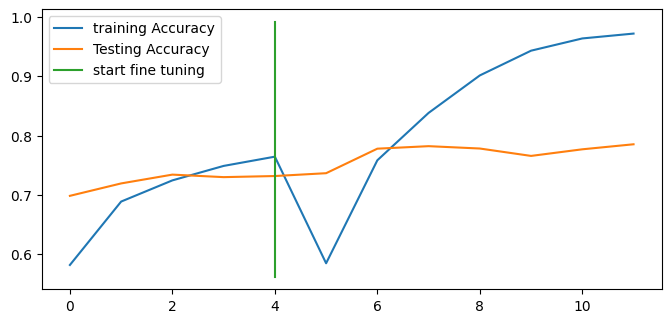

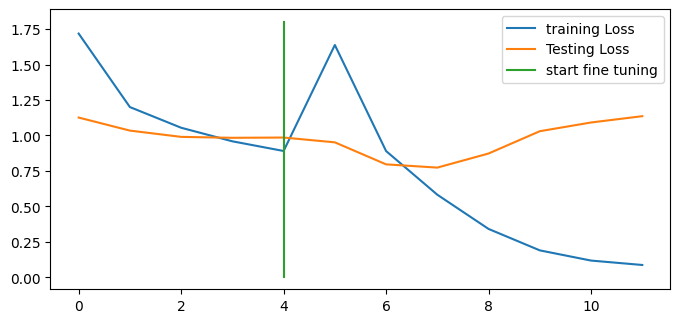

In [ ]:
compare_history(history_0,history_2)

As per the above graphs , we see that fine tuning begins from 4th epoch. From the distance between 2 graphs we do observe some overfitting as there is a considerable gap in both training and testing accuracy as well as training and validation loss. This can also be justified from our training model results as we were able to achieve a training accuracy of approx 97% but a testing accuracy of 77.7% only.

Below we see that we have another version of our feature extraction model in which we have trained all the layers of efficientB0 architure which is our base model

In [ ]:
complete_fine_tuned_model=getModel(len(fine_tune_model_last_100.layers[1].layers))

compileModel(complete_fine_tuned_model,0.0001)

history_3=complete_fine_tuned_model.fit(
    train_data,
    epochs=15,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    initial_epoch=history_0.epoch[-1],
    validation_steps=int(0.15*len(test_data)),
    callbacks=[early_stopping_callback,checkpoint_callback,
               create_tensorboard_callback("Tensorboard_Training_Logs","Fine_Tuning_Model_4_All_layers")]
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
 output_float_32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-tra

Epoch 5/15
2368/2368 [==============================] - ETA: 0s - loss: 1.6313 - accuracy: 0.5865
Epoch 5: val_loss did not improve from 0.77366
2368/2368 [==============================] - 430s 156ms/step - loss: 1.6313 - accuracy: 0.5865 - val_loss: 0.9293 - val_accuracy: 0.7428
Epoch 6/15
2368/2368 [==============================] - ETA: 0s - loss: 0.8556 - accuracy: 0.7677
Epoch 6: val_loss improved from 0.77366 to 0.73209, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 371s 155ms/step - loss: 0.8556 - accuracy: 0.7677 - val_loss: 0.7321 - val_accuracy: 0.7921
Epoch 7/15
2368/2368 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.8457
Epoch 7: val_loss improved from 0.73209 to 0.69809, saving model to Model_checkpoints/checkpoint.ckpt
2368/2368 [==============================] - 373s 156ms/step - loss: 0.5476 - accuracy: 0.8457 - val_loss: 0.6981 - val_accuracy: 0.8051
Epoch 8/15
2368/2368 [======================

I was ale to achieve an accuracy of 78.5 % on our testing data in comparison to our feature extraction which was only 73%.

In [ ]:
complete_fine_tuned_model_results=complete_fine_tuned_model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.0515 - accuracy: 0.7844


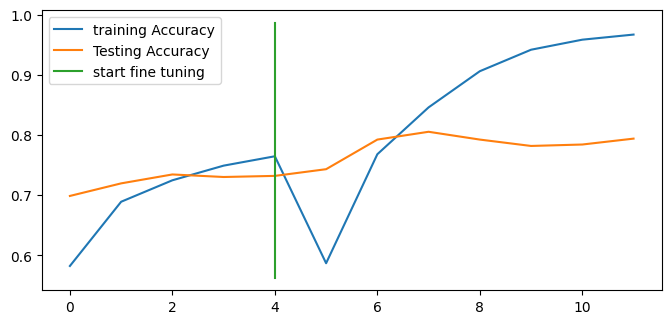

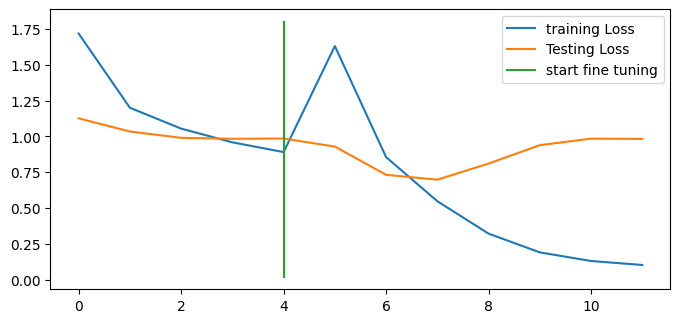

In [ ]:
compare_history(history_0,history_3)

As per the above graphs , we see that fine tuning begins from 4th epoch. From the distance between 2 graphs we do observe some overfitting as there is a considerable gap in both training and testing accuracy as well as training and validation loss. This can also be justified from our training model results as we were able to achieve a training accuracy of approx 96% but a testing accuracy of 78% only.

Below I have created a data frame which list all the models I have created so far and their validation loss and validation accuracy

In [ ]:
import pandas as pd
results=pd.DataFrame({
    "Models":[
              "feature_extraction_model",
              "fine_tune_model_last_50",
              "fine_tune_model_last_100",
              "complete_fine_tuned_model"
    ],
    "Validation_Accuracy":[
              results_feature_extraction_model[1],
              fine_tune_model_last_50_results[1],
              fine_tune_model_last_100_results[1],
              complete_fine_tuned_model_results[1]
    ],
    "Validation_Loss":[
              results_feature_extraction_model[0],
              fine_tune_model_last_50_results[0],
              fine_tune_model_last_100_results[0],
              complete_fine_tuned_model_results[0]
    ]
})

In [ ]:
results

Models  Validation_Accuracy  Validation_Loss
0   feature_extraction_model             0.731604         0.979443
1    fine_tune_model_last_50             0.752000         1.354138
2   fine_tune_model_last_100             0.776475         1.177832
3  complete_fine_tuned_model             0.784356         1.051471

In [ ]:
models={
    "feature_extraction_model":feature_extraction_model,
    "fine_tune_model_last_50":fine_tune_model_last_50,
    "fine_tune_model_last_100":fine_tune_model_last_100,
    "complete_fine_tuned_model":complete_fine_tuned_model
}

In [ ]:
best_model=models[results[results["Validation_Accuracy"]==results["Validation_Accuracy"].max()]["Models"].iloc[0]]

In [ ]:
best_model.evaluate(test_data)

790/790 [==============================] - 59s 74ms/step - loss: 1.0515 - accuracy: 0.7844


[1.0514711141586304, 0.784356415271759]

After creating the model , and selecting our best model it is time to actually test our model on custom image. I have created a zip file in my repository which consists of some custom images. These images are used as a final step of validation for our model.

In [ ]:
!wget https://github.com/nagnimit03/Food101-EfficientNets-ComputerVision/raw/main/custom_food_images.zip

--2023-07-28 22:04:42--  https://github.com/nagnimit03/Food101-EfficientNets-ComputerVision/raw/main/custom_food_images.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nagnimit03/Food101-EfficientNets-ComputerVision/main/custom_food_images.zip [following]
--2023-07-28 22:04:42--  https://raw.githubusercontent.com/nagnimit03/Food101-EfficientNets-ComputerVision/main/custom_food_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14988912 (14M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  14.29M  --.-KB/s    in 0.05s   

2023

In [ ]:
import zipfile
x=zipfile.ZipFile("/content/custom_food_images.zip")
x.extractall()
x.close()

In [ ]:
custom_images_filepath="/content/custom_food_images"
custom_images_filenames=[]
import os
for i in os.listdir("/content/custom_food_images"):
  custom_images_filenames.append(custom_images_filepath+"/"+i)

In [ ]:
def transform_image(filename):
  img=tf.io.read_file(filename)

  img=tf.io.decode_image(img,3)

  return tf.image.resize(img,[224,224])

1/1 [==============================] - 0s 30ms/step


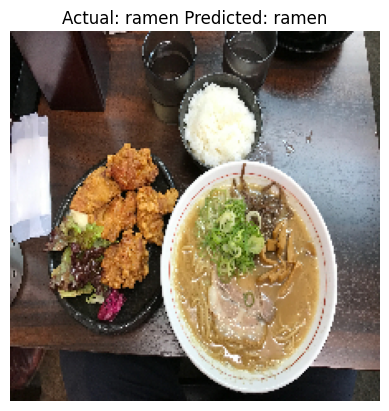

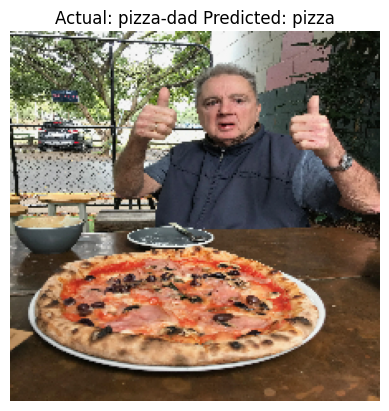

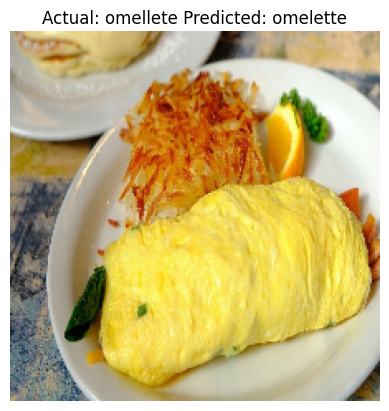

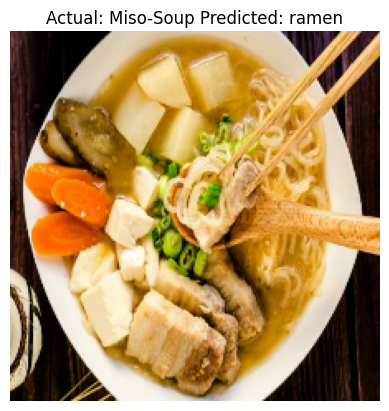

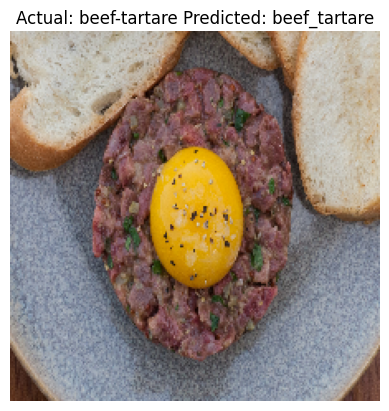

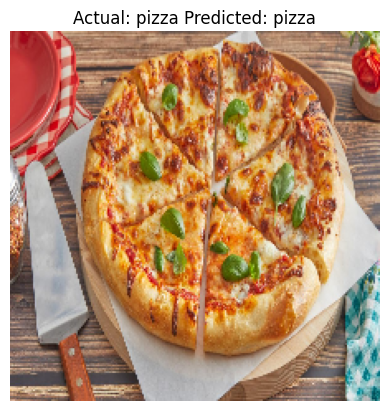

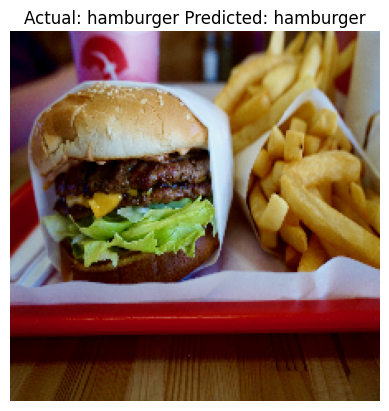

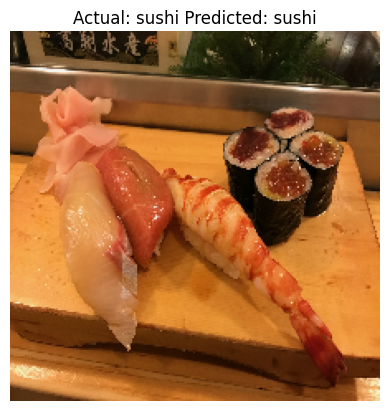

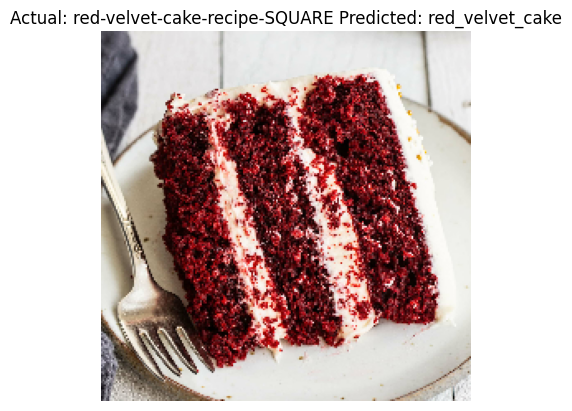

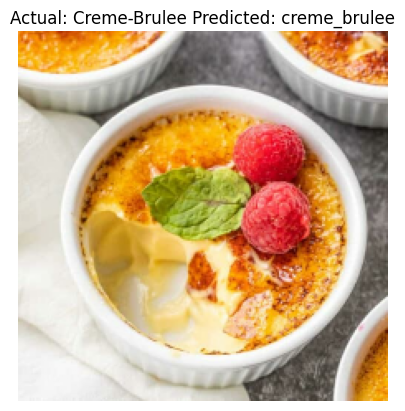

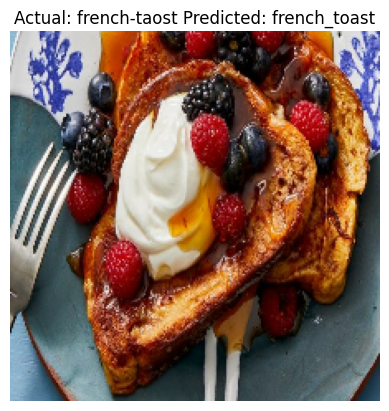

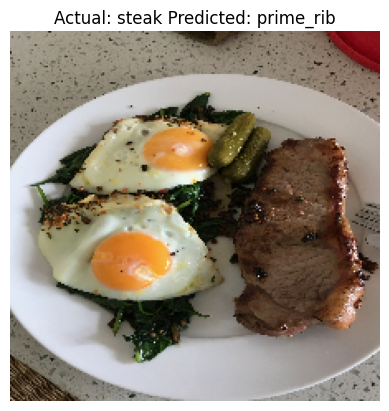

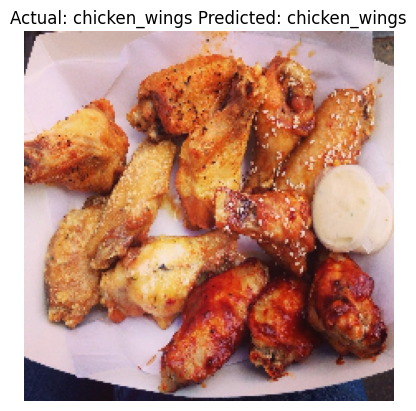

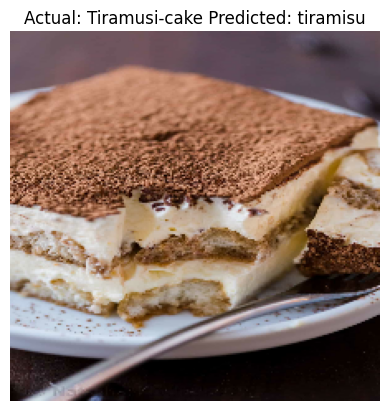

In [ ]:

import numpy as np
for i in custom_images_filenames:
  if(i=='/content/custom_food_images/.DS_Store' or i=='/content/custom_food_images/.ipynb_checkpoints'):
    continue
  actual_label=i.split("/")[3].split(".")[0]
  img=transform_image(i)
  pred_prob=best_model.predict(tf.expand_dims(img,axis=0))
  predicted_custom_class=class_names[np.argmax(pred_prob)]
  plt.figure()
  plt.imshow(img/255)
  plt.axis(False)
  plt.title("Actual: "+actual_label+" Predicted: "+predicted_custom_class)


In [ ]:
ds_info.features['label'].class_names

AttributeError: ignored